# CAE

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import pydot
import graphviz

tf.enable_eager_execution()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load and split image paths

In [2]:
tagged_image_paths = list(pathlib.Path('./dataset/tiles-resized/').glob('*.jpg'))
untagged_image_paths = list(pathlib.Path('./dataset/extra-tiles-untagged/').glob('*.jpg'))
image_paths = [str(path) for path in (tagged_image_paths + untagged_image_paths)]
random.shuffle(image_paths)

# train-test split
dataset_size = len(image_paths)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_paths = image_paths[:train_size]
val_paths = image_paths[train_size:train_size+val_size]
test_paths = image_paths[train_size+val_size:]

## Create datasets, preprocessing

Instructions for updating:
Colocations handled automatically by placer.
train size 1756
val size 376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test size 380


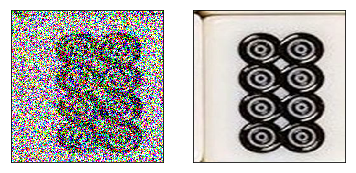

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


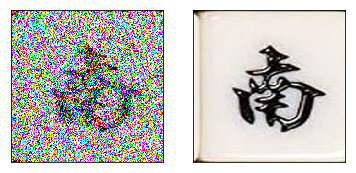

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


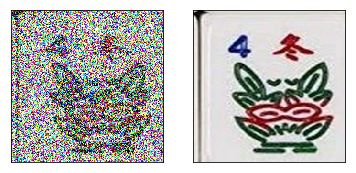

In [3]:
def show_noisy_image_sample(ds):
    for n, (noisy, orig) in enumerate(ds.take(3)):
        plt.subplot(1,2,1)
        plt.imshow(noisy)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2)
        plt.imshow(orig)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

def read_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

def rotate_image(image):
    image = tf.image.rot90(image)
    return image
    
def add_noise_to_x(x, y):
    x += tf.random.normal(shape=x.shape, mean=0.0, stddev=1.0)
    return x, y

def get_dataset(paths):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
    paired_ds = tf.data.Dataset.zip((image_ds, image_ds))
    paired_ds = paired_ds.map(map_func=add_noise_to_x, num_parallel_calls=AUTOTUNE)
    return paired_ds
    
train_ds = get_dataset(train_paths)
train_size *= 4
print('train size', train_size)
val_ds = get_dataset(val_paths)
val_size *= 4
print('val size', val_size)
test_ds = get_dataset(test_paths)
test_size *= 4
print('test size', test_size)

show_noisy_image_sample(test_ds)

## Train CAE Model

In [4]:
batch_size = 32
lr = 3e-3
b1 = 0.9
b2 = 0.99
config_str = str(batch_size)+'_adam_'+str(lr)+'_'+str(b1)+'_'+str(b2)+'final0514'

train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

encoder = keras.Sequential(layers=[
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu', input_shape=(320,320,3)),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='selu'),
], name='encoder')

decoder = keras.Sequential(layers=[
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='selu', input_shape=(16,16,16)),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid'),
], name='decoder')

cae_input = keras.Input(shape=(320,320,3))
cae_output = decoder(encoder(cae_input))
cae = keras.Model(inputs=cae_input, outputs=cae_output)

optim = keras.optimizers.Adam(lr=lr, beta_1=b1, beta_2=b2)
cae.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

cae.summary()

cae.fit(x=train_ds_batch,
        epochs=40,
        steps_per_epoch=int(train_size/batch_size),
        validation_data=val_ds_batch,
        validation_steps=int(val_size/batch_size),
        callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/cae/'+config_str)
                   ,keras.callbacks.ModelCheckpoint('./models/cae_best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)]
            )

# load best weights during training
cae.load_weights('./models/cae_best_weights.h5')

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
encoder (Sequential)         (None, 16, 16, 16)        18656     
_________________________________________________________________
decoder (Sequential)         (None, 320, 320, 3)       39491     
Total params: 58,147
Trainable params: 58,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
Instructions for updating:
Use tf.cast instead.
54/54 [==============================] - 29s 540ms/step - loss: 0.0423 - acc: 0.4814 - val_loss: 0.0210 - val_acc: 0.5571
Epoch 2/40
54/54 [==============================] - 16s 306ms/step - loss: 0.0213 - acc: 0.5530 - val_loss: 0.0181 - val_acc: 0.5855
Epoch 3/40
54/54 [======================

## Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


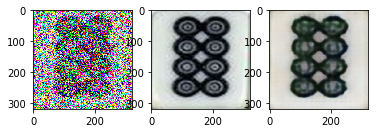

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


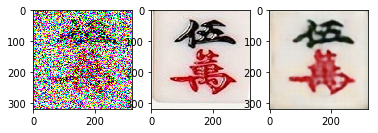

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


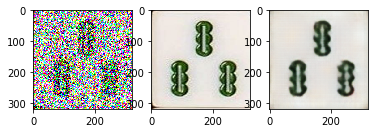

In [5]:
for n, (noisy, orig) in enumerate(val_ds.take(3)):
    plt.subplot(1,3,1)
    plt.imshow(noisy)
    plt.subplot(1,3,2)
    plt.imshow(orig)
    plt.subplot(1,3,3)
    pred = cae.predict_on_batch(x=noisy[np.newaxis,:])[0]
    plt.imshow(pred)
    plt.show()

## Test CAE Model

In [6]:
test_ds_batch = test_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=test_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

cae.evaluate(x=test_ds_batch, steps=int(test_size/batch_size))

11/11 [==============================] - 3s 269ms/step - loss: 0.0059 - acc: 0.7225


[0.005903765601529317, 0.7225137]

## Save models

In [7]:
encoder.save('./models/encoder_final.h5')
decoder.save('./models/decoder_final.h5')

## Verify saved models

1/1 [==============================] - 3s 3s/step - loss: 0.0060 - acc: 0.7500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


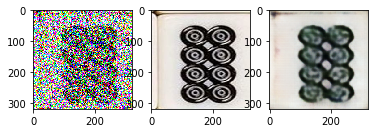

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


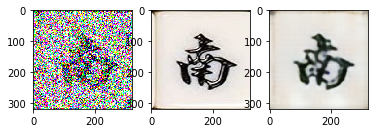

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


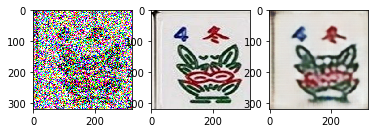

In [8]:
test_ds_batch = test_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=test_size))\
    .batch(32)\
    .prefetch(buffer_size=AUTOTUNE)

saved_encoder = keras.models.load_model('./models/encoder_final.h5')
saved_decoder = keras.models.load_model('./models/decoder_final.h5')

saved_cae_input = keras.Input(shape=(320,320,3))
saved_cae_output = saved_decoder(saved_encoder(saved_cae_input))
saved_cae = keras.Model(inputs=saved_cae_input, outputs=saved_cae_output)

saved_cae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
saved_cae.evaluate(x=test_ds_batch, steps=1)

for n, (noisy, orig) in enumerate(test_ds.take(3)):
    plt.subplot(1,3,1)
    plt.imshow(noisy)
    plt.subplot(1,3,2)
    plt.imshow(orig)
    plt.subplot(1,3,3)
    pred = saved_cae.predict_on_batch(x=noisy[np.newaxis,:])[0]
    plt.imshow(pred)
    plt.show()

## Generate model diagram

In [9]:
import pydot
import graphviz
keras.utils.plot_model(
    encoder,
    to_file='encoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)
keras.utils.plot_model(
    decoder,
    to_file='decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)